## Post-Analysis

다음 물음에 답하고자 합니다:

- 어떤 달에 가장 계약 체결량이 많은가?
- 특정 시기 전/후로만 등장한 단어가 있는가? 있다면 무엇인가?
- 구매 내역에서 가장 많이 언급된 학과는 어디일까?

In [42]:
import pandas


def load() -> pandas.DataFrame:
    return pandas.read_csv(f'preprocessed.csv')

In [43]:
import ast
import numpy
from matplotlib import pyplot as plt


def group_by_year_month():
    data = load()
    data['계약일'] = pandas.to_datetime(data['계약일'], format='%Y-%m-%d')
    data['연'] = data['계약일'].dt.year
    data['월'] = data['계약일'].dt.month
    data['토큰'] = data['토큰'].map(lambda x: ast.literal_eval(x))
    data['토큰수'] = data['토큰'].map(lambda x: len(x))
    data['누적'] = 1
    grouped = data.groupby(['연', '월'], as_index=False).agg({'토큰': 'sum', '계약금액': 'sum', '누적': 'sum', '토큰수': 'sum'})

    return grouped


def plot_purchase_volumes():
    g = group_by_year_month()

    g['연월'] = g['연'].astype(str) + '-' + g['월'].astype(str)

    fig = g.plot.bar(x='연월', y='누적', figsize=(40, 20))

    for index, row in g.iterrows():
        if row['월'] in [12, 1, 2]:
            fig.annotate(row['연월'], color='blue', xy=(index - 1, row['누적'] + 3),
                         bbox=dict(boxstyle='round,pad=0.3', fc='red', alpha=0.3))

In [106]:
group_by_year_month()

,연,월,토큰,계약금액,누적,토큰수
0,2013,1,"[학생복, 센터, 비품]",3720000,1,3
1,2013,2,"[신임, 교수, 이영수, 연구실, 무용, 집기, 학년, 전기, 우수, 졸업생, 표창...",79604920,16,72
2,2013,3,"[강의실, 책상, 의자, 실험실, 습기, 자재, 학생회, 사물함, 제물포, 캠퍼스,...",197123050,35,125
3,2013,4,"[전공, 자재, 학생회, 비품, 실험, 실습, 자재, 태블릿, 컴퓨터, 제물포, 캠...",843598300,32,122
4,2013,5,"[인천대학교, 창업, 원단, 맥북, 교육, 용기, 자재, 컴퓨터, 배드민턴, 운동,...",621530740,22,69
...,...,...,...,...,...,...
103,2021,8,"[학사, 행정, 사무, 용품, 학사, 행정, 사무, 용품, 체육, 진흥, 교비, 상...",153711827,139,633
104,2021,9,"[홍보, 스티커, 용지, 규정, 검색, 시스템, 자료, 백업, 외장하드, 사무, 용...",329871855,179,764
105,2021,10,"[학장, 프린트, 토너, 트라이버, 시티, 인강, 홍보, 홍보물, 실험, 실습, 재...",170265801,157,686
106,2021,11,"[실험, 실습, 재료, 브로콜리, 실험, 실습, 재료, 아세톤, 생명, 나노, 바이...",472623164,354,1585


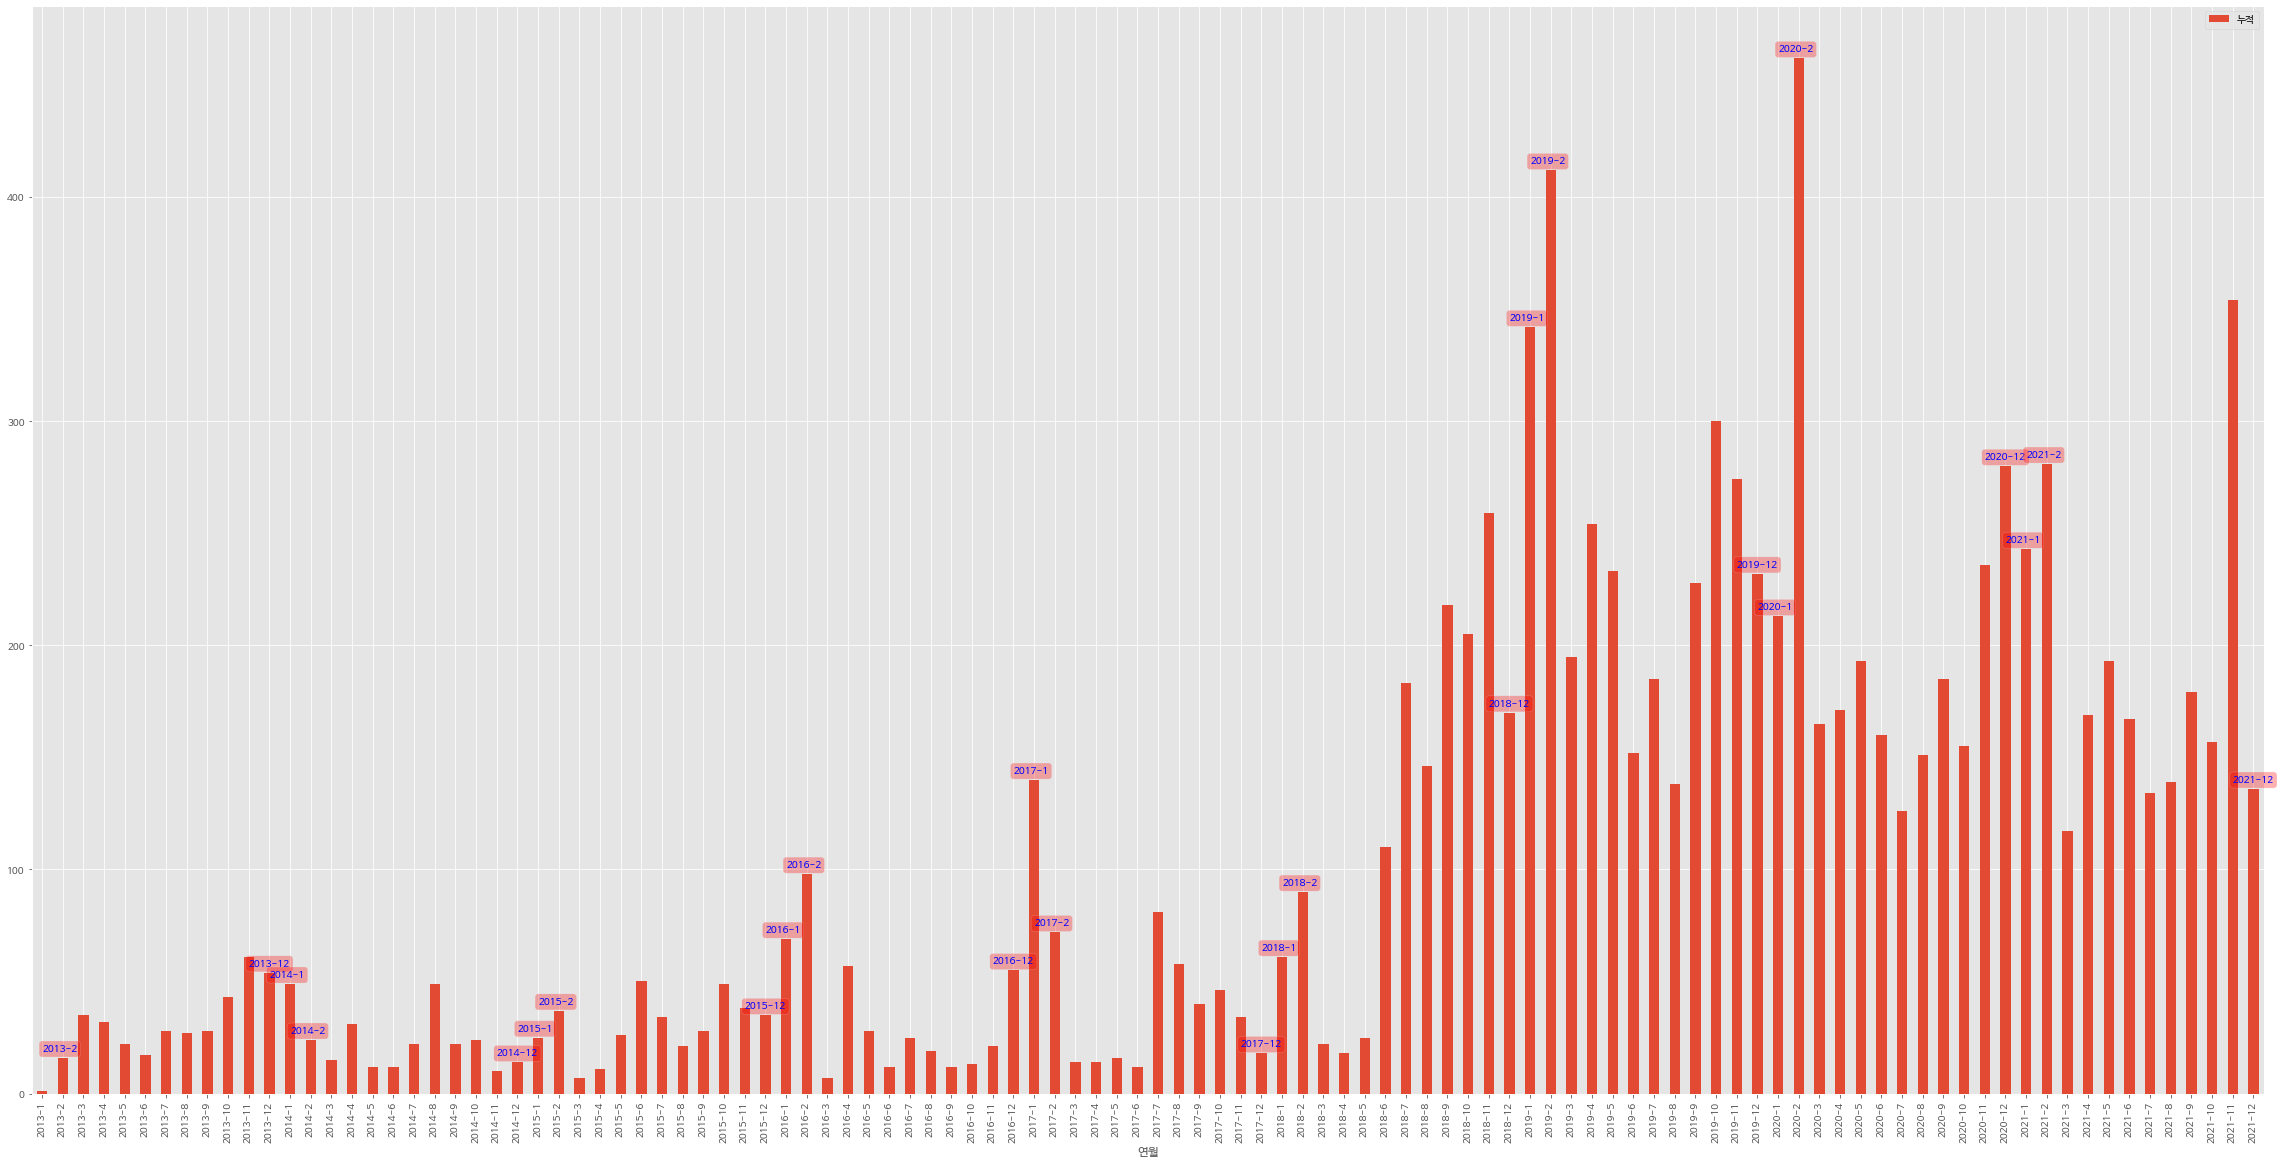

In [44]:
plot_purchase_volumes()

## 어떤 달에 가장 계약 체결량이 많은가?

### 빌드업

간단한 bar plot을 그려보고자 하였습니다.

x축은 연월, y축은 그 달의 구매량입니다.

### 결과

역시나 연말연시에(12, 1, 2월) 가장 물품 구매가 많았습니다. 2학기가 시작되는 8월~10월 즈음은 예상과 달리 의외로 구매량이 적었습니다.

In [72]:
def partially_appeared_keywords(min: int, max: int) -> pandas.DataFrame:
    g = group_by_year_month()

    all_tokens = list(set(g['토큰'].sum()))

    df = pandas.DataFrame()
    df['토큰'] = all_tokens
    df['등장연월'] = df['토큰'].map(lambda t: [f'{x[1]}-{x[2]}' for x in g.itertuples() if t in x[3]])

    return df[df['등장연월'].apply(lambda x: min <= len(x) <= max)]


def plot_per_token(token: str):
    font_family = 'NanumBarunGothic'

    plt.rc('font', family=font_family)
    plt.rcParams['axes.unicode_minus'] = False

    g = group_by_year_month()

    g['연월'] = g['연'].astype(str) + '-' + g['월'].astype(str)
    g['등장횟수'] = g['토큰'].map(lambda tokens: tokens.count(token))

    g.plot.line(x='연월', y='등장횟수', fontsize=12, title=f'"{token}" 등장 빈도')


def save_keywords_order_by_appearances():
    df = partially_appeared_keywords(3, 108)

    df['len'] = df['등장연월'].str.len()
    df.sort_values(by='len').to_csv('appearances.csv', index=False)

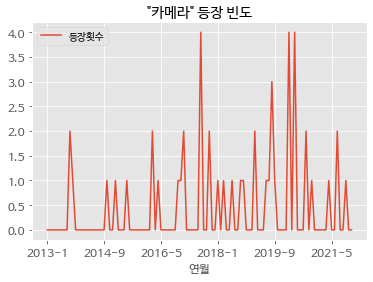

In [73]:
save_keywords_order_by_appearances()

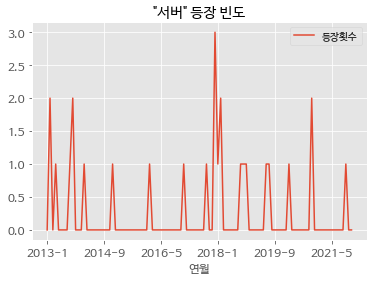

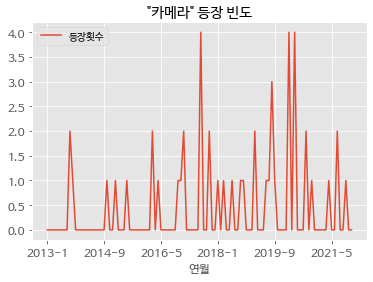

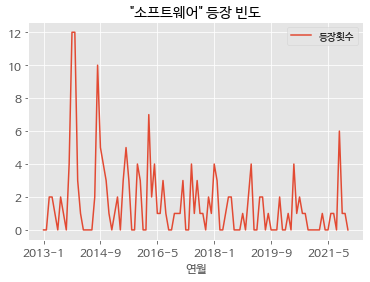

In [109]:
plot_per_token('방역')
plot_per_token('위생')
plot_per_token('마스크')
plot_per_token('약품')
plot_per_token('온라인')
plot_per_token('코로나')
plot_per_token('스튜디오')

## 특정 시기 전/후로 많이 등장한 단어가 있을까?

### 구상

먼저 단어와 등장 시기 사이의 관계를 알아보기 위해 `단어 to 등장한 월들의 리스트` 대응을 생성합니다.

이렇게 만들어진 대응 리스트 중 3개월 미만으로 등장한 단어를 배제한 1101건의 레코드를 csv 파일로 저장하여 가장 많이 등장한 단어부터 500개 가량을 눈으로 살펴보며 코로나-19와 관련 있을 것 같아 보이는 단어를 선정하였습니다.

### 진짜로 코로나-19 이후로 많이 등장했을까?

단어마다 기간별 등장 빈도를 한 눈에 보기 쉽게 알 수 있도록 차트를 그렸습니다.

### 2020년 초 이후로 많이 등장한 코로나-19 관련 단어들

- 방역
- 위생
- 마스크
- 약품
- 온라인
- 코로나
- 스튜디오

의외로 다음 단어들은 코로나-19 이후 눈에 띄게 달라진 점이 없었습니다:

- 서버
- 카메라
- 소프트웨어

In [114]:
deps = [
    '유아교육과',
    '경영학부',
    '건설환경공학',
    '예술체육대학',
    '영어영문학과',
    '컴퓨터공학부',
    '화학과',
    '공연예술학과',
    '무역학부',
    '경제학과',
    '임베디드시스템공학과',
    '체육교육과',
    '생명공학전공',
    '생명과학전공',
    '체육학부',
    '수학교육과',
    '계약학과',
    '인문대학',
    '신소재공학과',
    '일어교육과',
    '행정학과',
    '창의인재개발학과',
    '한국통상전공',
    '생명과학부',
    '운동건강학부',
    '정치외교학과',
    '공과대학',
    '국어교육과',
    '사회과학대학',
    '역사교육과',
    '경영대학',
    '동북아통상전공',
    '도시공학과',
    '영어교육과',
    '에너지화학공학과',
    '중어중국학과',
    '생명공학부',
    '나노바이오전공',
    '정보통신공학과',
    '정보기술대학',
    '신문방송학과',
    '수학과',
    '산업경영공학과',
    '물리학과',
    '글로벌정경대학',
    '디자인학부',
    '불어불문학과',
    '테크노경영학과',
    '도시건축학부',
    '패션산업학과',
    '독어독문학과',
    '사범대학',
    '분자의생명전공',
    '기초교육원',
    '세무회계학과',
    '국어국문학과',
    '생명과학기술대학',
    '윤리교육과',
    '동북아국제통상학부',
    '메카트로닉스공학',
    '법학부',
    '도시행정학과',
    '건축공학',
    '안전공학과',
    '사회복지학과',
    '조형예술학부',
    '도시환경공학부',
    '일어일문학과',
    '환경공학',
    '문헌정보학과',
    '기계공학과',
    '도시건축학',
    '도시과학대학',
    '전자공학과',
    '전기공학과',
    '해양학과',
    '자연과학대학',
    '소비자학과'
]


def load_raw(list_num: int) -> pandas.DataFrame:
    return pandas.read_csv(f'list{list_num}.csv')


def deps_to_appearances() -> pandas.DataFrame:
    df = pandas.DataFrame()
    df['학과'] = deps

    combined = load_raw(1).append(load_raw(2)).append(load_raw(3))

    names = combined['계약명'].tolist()

    df['등장'] = df['학과'].map(lambda d: sum(map(lambda x: x.count(d), names)))

    return df.sort_values(by='등장', ascending=False)


def plot_deps_to_appearances():
    df = deps_to_appearances()[:10]

    df.plot.bar(x='학과', y='등장', fontsize=40, figsize=(40, 20))

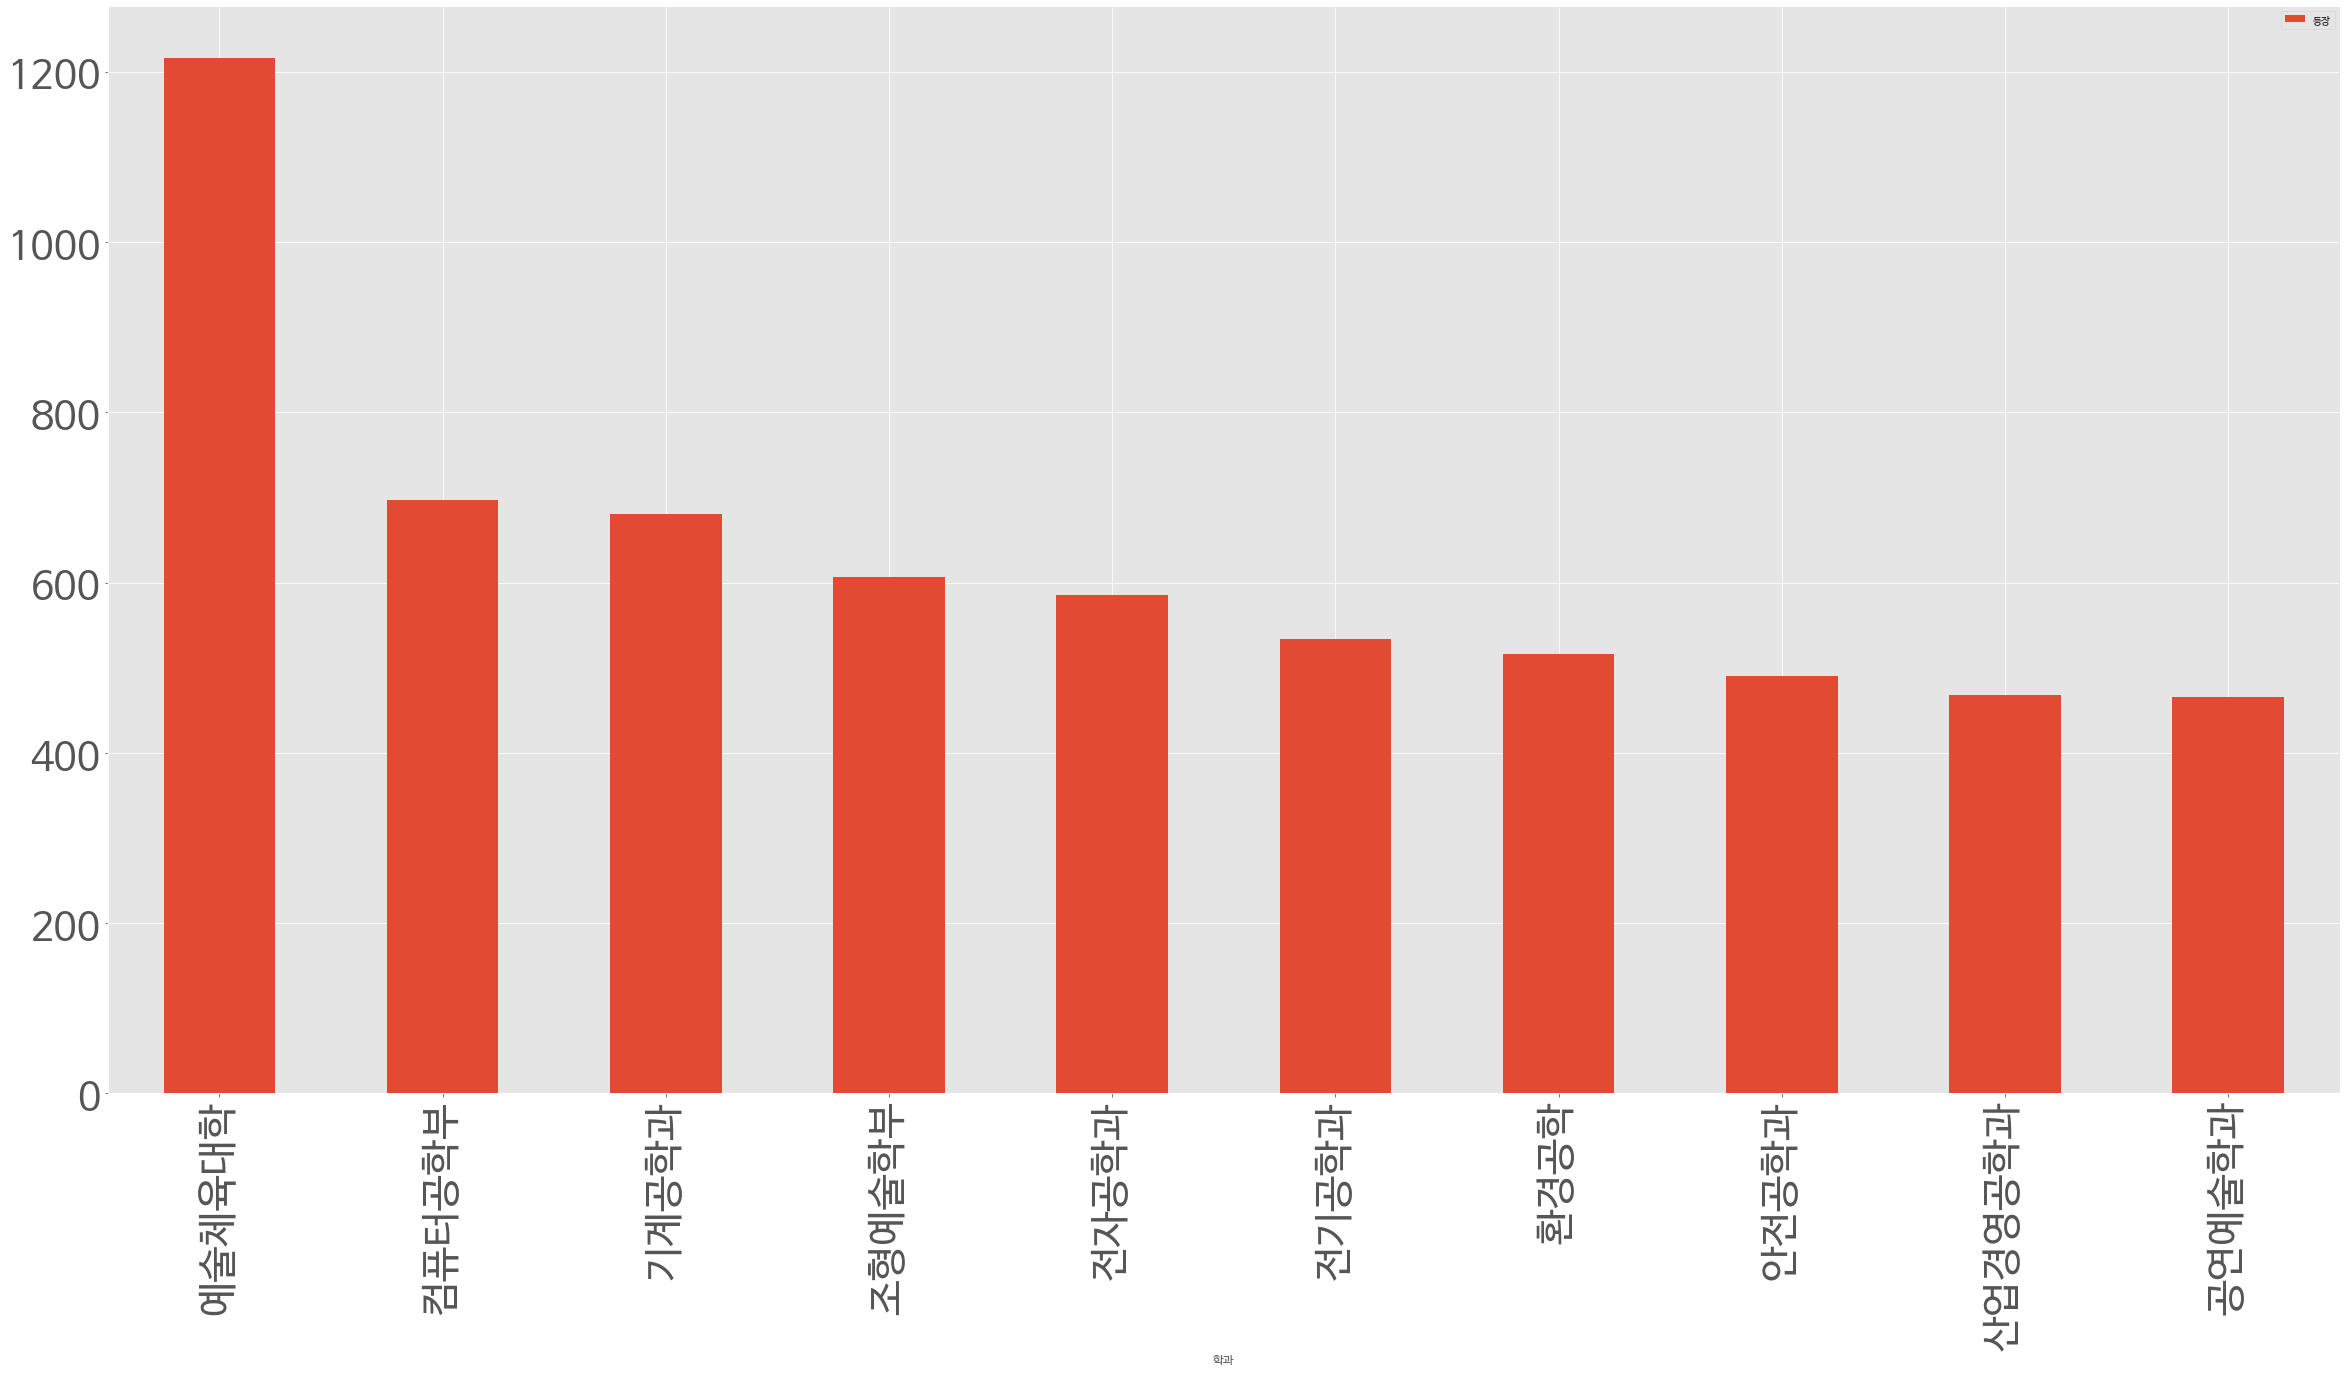

In [115]:
plot_deps_to_appearances()

## 구매 내역에서 가장 많이 언급된 학과는 어디일까?

### 준비

아까 전처리 과정에서 확보한 단과대/학과 이름 목록을 사용합니다.

모든 학과 이름 목록에 대해 각각의 이름이 구매 내역 전체에서 언급된 횟수를 구한 뒤 플롯을 그려봅니다.

### 결과

상위 10개 학과를 지정하여 바 차트를 그려 보니, 예술체육대학이 압도적 1위를 차지하였습니다.